In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open('../makemore/names.txt', 'r').read().splitlines()
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [6]:
vocab_size

27

In [8]:
# building the dataset

block_size = 3
def build_dataset(words):
    X,Y = [],[]

    for w in words:
        context = [0] * block_size # initialize the context
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [31]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * 0.2
# b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C,W1,W2,b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

12097

In [32]:
max_steps = 200000
batch_size = 32

lossi = []

for i in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    
    # forward pass
    emb = C[Xb] # (32,3,2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 # + b1 # (32, 100) # hidden layer pre-activation
    # ---------------------- Batch normalization ------------
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3025
  10000/ 200000: 2.3873
  20000/ 200000: 2.0512
  30000/ 200000: 2.2473
  40000/ 200000: 1.9260
  50000/ 200000: 1.9425
  60000/ 200000: 2.0009
  70000/ 200000: 2.3870
  80000/ 200000: 2.1952
  90000/ 200000: 2.1517
 100000/ 200000: 1.6974
 110000/ 200000: 2.3597
 120000/ 200000: 1.9226
 130000/ 200000: 2.0488
 140000/ 200000: 2.4412
 150000/ 200000: 2.0050
 160000/ 200000: 2.2453
 170000/ 200000: 2.2885
 180000/ 200000: 1.9807
 190000/ 200000: 2.3084


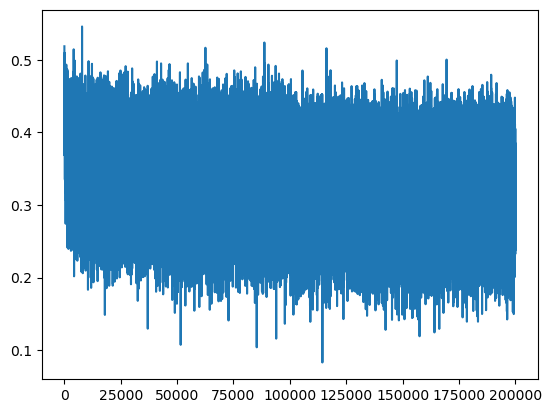

In [33]:
plt.plot(lossi)

In [34]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val'  : (Xdev,Ydev),
        'test' : (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.942589521408081
val 2.9806904792785645


In [35]:
# sample from model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

chrmahfatifhtvi.
kwrrxxheltyn.
kassangjorbitna.
perric.
kaqeight.
marthcerihv.
kalvinph.
bryndis.
quinthssoushawnidhi.
waxthm.
defrynixfkaudidhsabissaffigvagtasshayfranhlannishanksyarimbrosbasthl.
jenicoriffendeppla.
lucofedenstyn.
dayrinchamsalvynnand.
den.
bodh.
subrndaymp.
qwustzperichpdig.
rasirldykkmcrizabengjadyk.
kysesnantezimbreff.


---

# Torchifying / Refactoring the code